In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
import scipy.stats as st

In [2]:
df = pd.read_csv('cookie_cats.csv')
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


**userid**: id игрока

**version**: версия игры (gate_30 - контрольная, gate_40 - тестовая).

**sumgamerounds**: кол-во раундов сыгранных игроком

**retention_1**: Вернулся ли игрок в игру через 1 день после установки.

**retention_7**: Вернулся ли игрок в игру через 7 дней после установки.

In [3]:
# количество строк и столбцов
df.shape

(90189, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [5]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


В столбце **sum_gamerounds** максимальное значение очень высокое среди всех, проверим выброс ли это

In [6]:
df.nlargest(5, ['sum_gamerounds'])

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,0,1
7912,871500,gate_30,2961,1,1
29417,3271615,gate_40,2640,1,0
43671,4832608,gate_30,2438,1,1
48188,5346171,gate_40,2294,1,1


однозначно можно сказать, что это выброс. Удалим его

In [7]:
df = df[df.sum_gamerounds < 3000]
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018800e+04,90188.000000,90188.000000,90188.000000
mean,4.998397e+06,51.320253,0.445214,0.186056
std,2.883298e+06,102.682719,0.496992,0.389154
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512211e+06,5.000000,0.000000,0.000000
50%,4.995804e+06,16.000000,0.000000,0.000000
75%,7.496461e+06,51.000000,1.000000,0.000000
max,9.999861e+06,2961.000000,1.000000,1.000000


##### Показатели числа человек в группах значительно отличаются

In [8]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

##### В наборе нет нулевых данных

### Проверка на нормальность

H0: Данные распределены нормально.
H1: Данные распределены не нормально

Проверяем с помощью теста Колмогорова-Смирнова, так как выборка больше 5000 и тест Шапиро не даст точных результатов

In [9]:
# контрольная группа
control = df[df.version == 'gate_30'].sum_gamerounds
test_stat, pvalue = st.kstest(control, 'norm')
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.8724, p-value = 0.0000


In [10]:
# тестовая группа
test = df[df.version == 'gate_40'].sum_gamerounds
test_stat, pvalue = st.kstest(test, 'norm')
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.8707, p-value = 0.0000


**Вывод**: для обеих групп p-value<0.05, значит распределение в обеих группах не наормальное

### Проверка на однородность дисперсии:

In [11]:
test_stat, pvalue = st.levene(control,test)
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.0751, p-value = 0.7840


**Вывод**: так как p-value >0.05, то дисперсия однородна.

**Применение гипотез:**

Согласно «Нормальному распределению» и «Предположению об однородности дисперсии» показано, что первый контроль НЕ принимает нулевую гипотезу, а второй принимает её. Это означает, что мы должны использовать команду mannwtihneyu() для применения гипотезы.

Критерий Манна-Уитни основан на сравнении каждого наблюдения xi в первой выборке с каждым наблюдением yj в другой выборке. Общее количество попарных сравнений, которые можно сделать, равно nxny.1

In [12]:
test_stat, pvalue = st.mannwhitneyu(control,test)
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 1024285761.5000, p-value = 0.0509


**Вывод:**

Так как p-value примерно равно 0.05, то этого теста не будет достаточно для принятия решения о разнице в выборках

### Найдем сколько пользователь играет

Text(0.5, 1.0, 'Число раундов, которые сыграли игроки в течении недели')

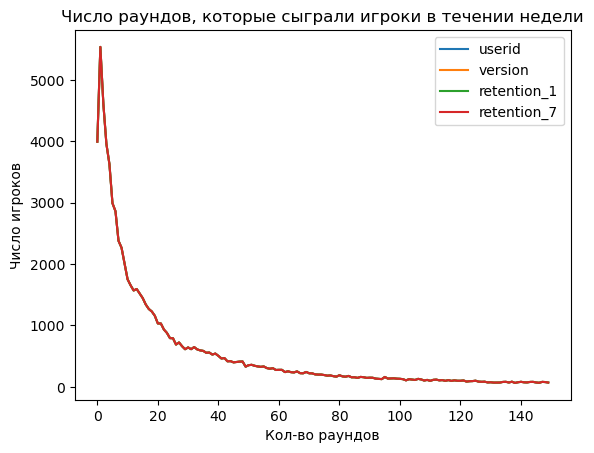

In [13]:
plot_df = df.groupby('sum_gamerounds').count()

ax = plot_df[:150].plot()
ax.set_xlabel('Кол-во раундов')
ax.set_ylabel('Число игроков')
ax.set_title('Число раундов, которые сыграли игроки в течении недели')

#### График показывает, что большенство пользователей играет менее 20 раундов. в неделю

### Посмотрим активность пользователей в игре в течении недели

#### для этого немного изменим распределение в группах

In [14]:
A = df[df.version == 'gate_30']
print(A.head())
B = df[df.version == 'gate_40']
print(B.head())

plt.style.use('ggplot')
bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]
plot_GA = pd.DataFrame(A.groupby(pd.cut(A['sum_gamerounds'],
                                              bins=bins)).count())
plot_GB = pd.DataFrame(B.groupby(pd.cut(B['sum_gamerounds'],
                                              bins=bins)).count())

    userid  version  sum_gamerounds  retention_1  retention_7
0      116  gate_30               3            0            0
1      337  gate_30              38            1            0
6     1066  gate_30               0            0            0
11    2101  gate_30               0            0            0
13    2179  gate_30              39            1            0
   userid  version  sum_gamerounds  retention_1  retention_7
2     377  gate_40             165            1            0
3     483  gate_40               1            0            0
4     488  gate_40             179            1            1
5     540  gate_40             187            1            1
7    1444  gate_40               2            0            0


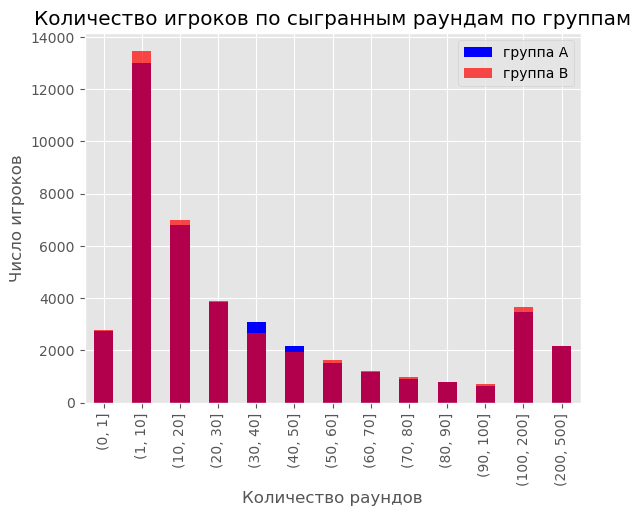

In [15]:
ax = plot_GA.plot(kind = 'bar', y='userid', color = 'blue', alpha = 1,
                  title = 'Количество игроков по сыгранным раундам по группам')
plot_GB.plot(kind = 'bar', y = 'userid', ax = ax, color = 'red', alpha = 0.7)
ax.set_xlabel('Количество раундов')
ax.set_ylabel('Число игроков')
plt.legend(['группа A', 'группа B'])


График показывает, что между версиями нет большой разници. Есть небольшие различия в пределах 50 раундов

### Посмотрим удержание пользователей в течении 1 дня

In [16]:
oneday = df.retention_1.groupby(df.version).sum()/df.retention_1.groupby(df.version).count()
print(oneday*100)

version
gate_30    44.819795
gate_40    44.228275
Name: retention_1, dtype: float64


#### Обе версии имеют практически одинаковые результаты.

### Посмотрим удержание пользователей в течении недели

In [17]:
oneday = df.retention_7.groupby(df.version).sum()/df.retention_7.groupby(df.version).count()
print(oneday*100)

version
gate_30    19.018323
gate_40    18.200004
Name: retention_7, dtype: float64


#### У контрольной версии удержание игроков в течении недели выше

### Общий вывод:
По статистическим показателям разницы между контрольной и тестовой версии игры нет. По количеству сыгранных раундов обе версии показали примерно одинаковые результаты, следовательно, изменение версии не влияет на активность в игре. Тестовая версия показала себя хуже в удержании игроков в течении недели, следовательно, в целях удержании аудитории стоит оставить контрольную версию игры